<a href="https://colab.research.google.com/github/GreenStreetQuant/Random-Forest-Classifier/blob/master/github_rf_next_week_nio_price_81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np
from feature_selector import FeatureSelector
from statsmodels.tsa.api  import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from fastquant import backtest
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

uploaded = files.upload()


Last 2 years of NIO Stock Price data from my brokerage software


In [ ]:
data = pd.read_csv('nio.txt', sep=",")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 9 columns):
Date      509 non-null object
Time      509 non-null object
Open      509 non-null float64
High      509 non-null float64
Low       509 non-null float64
Close     509 non-null float64
Vol       509 non-null int64
OI        509 non-null int64
Volume    509 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 35.9+ KB


Getting the last 2 years of SPY to compare to "Market"

In [ ]:
data_sp = pd.read_csv('spy.txt', sep=',')
data_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 9 columns):
Date      1260 non-null object
Time      1260 non-null object
Open      1260 non-null float64
High      1260 non-null float64
Low       1260 non-null float64
Close     1260 non-null float64
Vol       1260 non-null int64
OI        1260 non-null int64
Volume    1260 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 88.7+ KB


In [ ]:
data.head()

,Date,Time,Open,High,Low,Close,Vol,OI,Volume
0,09/12/2018,15:00,6.00,6.93,5.35,6.60,66848996,0,0.0
1,09/13/2018,15:00,6.62,12.69,6.52,11.60,158346488,0,158346488.0
2,09/14/2018,15:00,12.66,13.80,9.22,9.90,172473559,0,172473559.0
3,09/17/2018,15:00,9.61,9.75,8.50,8.50,56323875,0,56323875.0
4,09/18/2018,15:00,8.73,9.10,7.67,7.68,41827593,0,41827593.0


In [ ]:
data_sp.head()

,Date,Time,Open,High,Low,Close,Vol,OI,Volume
0,09/18/2015,15:00,195.71,197.56,194.96,195.45,223657456,0,0.0
1,09/21/2015,15:00,196.44,197.68,195.21,196.46,105726209,0,105726209.0
2,09/22/2015,15:00,193.88,194.46,192.56,193.91,153890876,0,153890876.0
3,09/23/2015,15:00,194.11,194.67,192.91,193.60,92790620,0,92790620.0
4,09/24/2015,15:00,192.15,193.45,190.56,192.90,159378840,0,159378840.0


In [ ]:
#the data for SPY just so happened to start in 2015, so 
#I have to get the data to start on the same index 
data_sp[data_sp['Date']=='09/12/2018']
data_sp = data_sp.iloc[751:]
data_sp = data_sp.reset_index(drop=True)
data_sp.head()

,Date,Time,Open,High,Low,Close,Vol,OI,Volume
0,09/12/2018,15:00,289.06,289.80,288.23,289.12,59810758,0,59810758.0
1,09/13/2018,15:00,290.30,291.04,290.00,290.83,51034222,0,51034222.0
2,09/14/2018,15:00,291.06,291.27,290.00,290.88,55079875,0,55079875.0
3,09/17/2018,15:00,290.82,290.86,289.03,289.34,68244043,0,68244043.0
4,09/18/2018,15:00,289.58,291.58,289.55,290.91,61930407,0,61930407.0


In [ ]:
#Exponentially smoothing the data to get rid of any noise
#for Exponentiall smoothing I used 0.2 α
def exp_smooth_data(data):

  smooth_list = []

  #first value y for s 
  smooth_list.append(data.iloc[0])

  for v in data[1:]:
    st = 0.2 * v + (1 - 0.2) * smooth_list[-1]
    smooth_list.append(st)

  return smooth_list 


#inputting the original data into my exponentiall smoothing function
df_smoothed = pd.DataFrame()

close_smooth = exp_smooth_data(data['Close'])

df_smoothed['close_smooth'] = close_smooth

open_smooth = exp_smooth_data(data['Open'])

df_smoothed['Open_smooth'] = open_smooth

high_smooth = exp_smooth_data(data['High'])

df_smoothed['high_smooth'] = high_smooth

low_smooth = exp_smooth_data(data['Low'])

df_smoothed['low_smooth'] = low_smooth

volume_smooth = exp_smooth_data(data['Volume'])

df_smoothed['volume_smooth'] = volume_smooth

df_smoothed.head()

,close_smooth,Open_smooth,high_smooth,low_smooth,volume_smooth
0,6.6000,6.000000,6.930000,5.350000,0.000000e+00
1,7.6000,6.124000,8.082000,5.584000,3.166930e+07
2,8.0600,7.431200,9.225600,6.311200,5.983015e+07
3,8.1480,7.866960,9.330480,6.748960,5.912889e+07
4,8.0544,8.039568,9.284384,6.933168,5.566863e+07


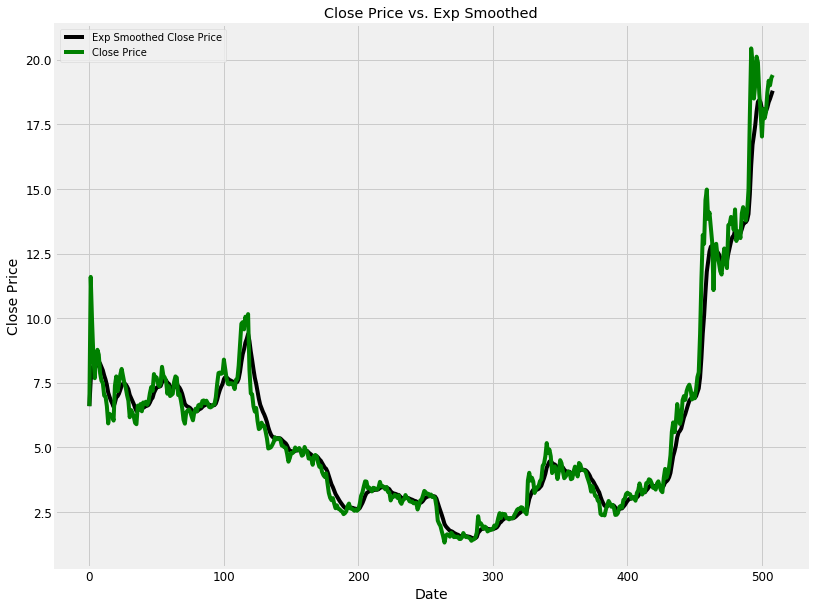

In [ ]:
#Charting the Original Close Price to the 
#new exponentially smoothed Close Price 
plt.figure(figsize=(12,10))
plt.plot(df_smoothed['close_smooth'],color='black',label='Exp Smoothed Close Price')
plt.plot(data['Close'],color='green',label='Close Price')
plt.grid(True)
plt.box(True)
plt.rcParams["figure.facecolor"] = "w"
plt.ylabel('Close Price'); 
plt.xlabel('Date');
plt.legend()
plt.title('Close Price vs. Exp Smoothed');

In [ ]:
#Exponentially smoothing the SPY data as well
df_sp_smoothed = pd.DataFrame()

close_smooth_sp = exp_smooth_data(data_sp['Close'])

df_sp_smoothed['close_smooth'] = close_smooth_sp
df_sp_smoothed.head()

,close_smooth
0,289.120000
1,289.462000
2,289.745600
3,289.664480
4,289.913584


In [ ]:
#Main indicator for some traders is RSI so I create
#a function to calculate that 
def computeRSI(data):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff > 0]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # we set com=time_window-1 so we get decay alpha=1/time_window

    up_chg_avg   = up_chg.ewm(com=14-1 , min_periods=14).mean()
    down_chg_avg = down_chg.ewm(com=14-1 , min_periods=14).mean()
    
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
#Creating my features off the Exponentially smoothed data
df_smoothed['rsi'] = computeRSI(df_smoothed['close_smooth'])
df_smoothed['william'] = (df_smoothed['high_smooth'].rolling(14).max() - df_smoothed['close_smooth'])/(df_smoothed['high_smooth'].rolling(14).max() - df_smoothed['low_smooth'].rolling(14).min()) * -100
df_smoothed['stch_osc'] = 100 * (df_smoothed['close_smooth'] - df_smoothed['low_smooth'].rolling(14).min())/(df_smoothed['high_smooth'].rolling(14).max() - df_smoothed['low_smooth'].rolling(14).min())
df_smoothed['price_rate_change'] = (df_smoothed['close_smooth'] - df_smoothed['close_smooth'].shift(14))/df_smoothed['close_smooth'].shift(14)
df_smoothed['log_price'] = np.log(df_smoothed['close_smooth'])
df_smoothed['log_mov'] = df_smoothed['log_price'].rolling(6).mean()
df_smoothed['log_diff'] = df_smoothed['log_price'] - df_smoothed['log_mov']
df_smoothed['fast_mov'] = df_smoothed['close_smooth'].rolling(3).mean()
df_smoothed['slow_mov'] = df_smoothed['close_smooth'].rolling(7).mean()
df_smoothed['mov_diff'] = df_smoothed['fast_mov'] - df_smoothed['slow_mov']
df_smoothed['mac_fast'] = df_smoothed['close_smooth'].rolling(7).mean()
df_smoothed['mac_slow'] = df_smoothed['close_smooth'].rolling(20).mean()
df_smoothed['mac_diff'] = df_smoothed['mac_fast'] - df_smoothed['mac_slow']
df_smoothed['volume_log'] = np.log(df_smoothed['volume_smooth'])
df_smoothed['pct_change'] = df_smoothed['close_smooth'].pct_change()
df_smoothed['z_score'] = (df_smoothed['close_smooth'] - df_smoothed['close_smooth'].rolling(7).mean())/df_smoothed['close_smooth'].std()
df_smoothed['sp_return'] = df_sp_smoothed['close_smooth'].pct_change(14)
df_smoothed['return_two_week'] = df_smoothed['close_smooth'].pct_change(14)
df_smoothed['return_day'] = df_smoothed['close_smooth'].pct_change(1)
df_smoothed['return_month'] = df_smoothed['close_smooth'].pct_change(5)
df_smoothed['return_two_day'] = df_smoothed['close_smooth'].pct_change(2)
df_smoothed['return_week'] = df_smoothed['close_smooth'].pct_change(5)
df_smoothed['return_diff_sp'] = df_smoothed['return_day'] - df_smoothed['sp_return']
df_smoothed['return_sp_std'] = df_smoothed['sp_return'].rolling(14).std()
df_smoothed['return_std'] = df_smoothed['return_week'].rolling(14).std()
df_smoothed['last_close'] = df_smoothed['close_smooth'].shift(14)
df_smoothed['last_open'] = df_smoothed['Open_smooth'].shift(14)
df_smoothed['last_high'] = df_smoothed['high_smooth'].shift(14)
df_smoothed['last_low'] = df_smoothed['low_smooth'].shift(14)
df_smoothed['high_low'] = df_smoothed['last_high'] - df_smoothed['last_low']
df_smoothed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


,close_smooth,Open_smooth,high_smooth,low_smooth,volume_smooth,rsi,william,stch_osc,price_rate_change,log_price,log_mov,log_diff,fast_mov,slow_mov,mov_diff,mac_fast,mac_slow,mac_diff,volume_log,pct_change,z_score,sp_return,return_two_week,return_day,return_month,return_two_day,return_week,return_diff_sp,return_sp_std,return_std,last_close,last_open,last_high,last_low,high_low
0,6.6000,6.000000,6.930000,5.350000,0.000000e+00,NaN,NaN,NaN,NaN,1.887070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.6000,6.124000,8.082000,5.584000,3.166930e+07,NaN,NaN,NaN,NaN,2.028148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.270858,0.151515,NaN,NaN,NaN,0.151515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0600,7.431200,9.225600,6.311200,5.983015e+07,NaN,NaN,NaN,NaN,2.086914,NaN,NaN,7.420000,NaN,NaN,NaN,NaN,NaN,17.907020,0.060526,NaN,NaN,NaN,0.060526,NaN,0.221212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.1480,7.866960,9.330480,6.748960,5.912889e+07,NaN,NaN,NaN,NaN,2.097772,NaN,NaN,7.936000,NaN,NaN,NaN,NaN,NaN,17.895230,0.010918,NaN,NaN,NaN,0.010918,NaN,0.072105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0544,8.039568,9.284384,6.933168,5.566863e+07,NaN,NaN,NaN,NaN,2.086219,NaN,NaN,8.087467,NaN,NaN,NaN,NaN,NaN,17.834927,-0.011487,NaN,NaN,NaN,-0.011487,NaN,-0.000695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#checking for NULL data
df_smoothed.isna().sum()

close_smooth          0
Open_smooth           0
high_smooth           0
low_smooth            0
volume_smooth         0
rsi                  14
william              13
stch_osc             13
price_rate_change    14
log_price             0
log_mov               5
log_diff              5
fast_mov              2
slow_mov              6
mov_diff              6
mac_fast              6
mac_slow             19
mac_diff             19
volume_log            0
pct_change            1
z_score               6
sp_return            14
return_two_week      14
return_day            1
return_month          5
return_two_day        2
return_week           5
return_diff_sp       14
return_sp_std        27
return_std           18
last_close           14
last_open            14
last_high            14
last_low             14
high_low             14
dtype: int64

In [ ]:
#Dropping the NULL Data
df_smoothed = df_smoothed.dropna()

In [ ]:
df_smoothed.head()

,close_smooth,Open_smooth,high_smooth,low_smooth,volume_smooth,rsi,william,stch_osc,price_rate_change,log_price,log_mov,log_diff,fast_mov,slow_mov,mov_diff,mac_fast,mac_slow,mac_diff,volume_log,pct_change,z_score,sp_return,return_two_week,return_day,return_month,return_two_day,return_week,return_diff_sp,return_sp_std,return_std,last_close,last_open,last_high,last_low,high_low
27,7.443060,7.565888,7.765836,7.238245,1.759144e+07,56.776322,-23.889661,76.110339,0.002610,2.007282,1.994212,0.013070,7.461388,7.296356,0.165033,7.296356,7.305819,-0.009463,16.682923,-0.004116,0.040024,-0.040642,0.002610,-0.004116,0.051001,-0.003244,0.051001,0.036525,0.018577,0.092576,7.423681,7.680120,7.988478,7.165297,0.823180
28,7.360448,7.588710,7.750669,7.190596,1.662486e+07,53.788628,-29.501440,70.498560,0.033053,1.996121,2.000643,-0.004522,7.425777,7.349656,0.076121,7.349656,7.261755,0.087901,16.626410,-0.011099,0.002944,-0.043872,0.033053,-0.011099,0.018113,-0.015170,0.018113,0.032772,0.018592,0.087473,7.124945,7.464096,7.710782,6.906238,0.804544
29,7.250358,7.418968,7.578535,7.042477,1.628024e+07,50.011784,-36.979755,63.020245,0.041725,1.981051,2.001123,-0.020072,7.351289,7.373725,-0.022436,7.373725,7.218804,0.154921,16.605463,-0.014957,-0.033657,-0.047520,0.041725,-0.014957,-0.019109,-0.025890,-0.019109,0.032563,0.018267,0.080035,6.959956,7.195277,7.478626,6.748990,0.729635
30,7.034287,7.305175,7.432828,6.859982,1.598216e+07,43.548565,-51.657367,48.342633,0.031728,1.950796,1.992865,-0.042068,7.215031,7.345837,-0.130806,7.345837,7.171143,0.174694,16.586984,-0.029802,-0.084997,-0.054648,0.031728,-0.029802,-0.057986,-0.044313,-0.057986,0.024846,0.018072,0.073462,6.817965,6.994221,7.232901,6.599192,0.633708
31,6.917429,7.098140,7.260262,6.737985,1.462347e+07,40.500138,-59.595412,40.404588,0.031471,1.934044,1.980117,-0.046073,7.067358,7.278098,-0.210740,7.278098,7.127415,0.150684,16.498138,-0.016613,-0.098397,-0.056034,0.031471,-0.016613,-0.074446,-0.045919,-0.074446,0.039421,0.017224,0.067985,6.706372,6.835377,7.044320,6.485354,0.558967


In [ ]:
df_complete = df_smoothed
df_complete.head()

,close_smooth,Open_smooth,high_smooth,low_smooth,volume_smooth,rsi,william,stch_osc,price_rate_change,log_price,log_mov,log_diff,fast_mov,slow_mov,mov_diff,mac_fast,mac_slow,mac_diff,volume_log,pct_change,z_score,sp_return,return_two_week,return_day,return_month,return_two_day,return_week,return_diff_sp,return_sp_std,return_std,last_close,last_open,last_high,last_low,high_low
27,7.443060,7.565888,7.765836,7.238245,1.759144e+07,56.776322,-23.889661,76.110339,0.002610,2.007282,1.994212,0.013070,7.461388,7.296356,0.165033,7.296356,7.305819,-0.009463,16.682923,-0.004116,0.040024,-0.040642,0.002610,-0.004116,0.051001,-0.003244,0.051001,0.036525,0.018577,0.092576,7.423681,7.680120,7.988478,7.165297,0.823180
28,7.360448,7.588710,7.750669,7.190596,1.662486e+07,53.788628,-29.501440,70.498560,0.033053,1.996121,2.000643,-0.004522,7.425777,7.349656,0.076121,7.349656,7.261755,0.087901,16.626410,-0.011099,0.002944,-0.043872,0.033053,-0.011099,0.018113,-0.015170,0.018113,0.032772,0.018592,0.087473,7.124945,7.464096,7.710782,6.906238,0.804544
29,7.250358,7.418968,7.578535,7.042477,1.628024e+07,50.011784,-36.979755,63.020245,0.041725,1.981051,2.001123,-0.020072,7.351289,7.373725,-0.022436,7.373725,7.218804,0.154921,16.605463,-0.014957,-0.033657,-0.047520,0.041725,-0.014957,-0.019109,-0.025890,-0.019109,0.032563,0.018267,0.080035,6.959956,7.195277,7.478626,6.748990,0.729635
30,7.034287,7.305175,7.432828,6.859982,1.598216e+07,43.548565,-51.657367,48.342633,0.031728,1.950796,1.992865,-0.042068,7.215031,7.345837,-0.130806,7.345837,7.171143,0.174694,16.586984,-0.029802,-0.084997,-0.054648,0.031728,-0.029802,-0.057986,-0.044313,-0.057986,0.024846,0.018072,0.073462,6.817965,6.994221,7.232901,6.599192,0.633708
31,6.917429,7.098140,7.260262,6.737985,1.462347e+07,40.500138,-59.595412,40.404588,0.031471,1.934044,1.980117,-0.046073,7.067358,7.278098,-0.210740,7.278098,7.127415,0.150684,16.498138,-0.016613,-0.098397,-0.056034,0.031471,-0.016613,-0.074446,-0.045919,-0.074446,0.039421,0.017224,0.067985,6.706372,6.835377,7.044320,6.485354,0.558967


In [ ]:
#Adding the label in this case I am going to make the label
#Next weeks Close price being Up 1, being down 0 
df_complete['win'] = np.where((df_complete['close_smooth'].shift(-5) > df_complete['close_smooth']), 1, 0)
df_complete.head()

,close_smooth,Open_smooth,high_smooth,low_smooth,volume_smooth,rsi,william,stch_osc,price_rate_change,log_price,log_mov,log_diff,fast_mov,slow_mov,mov_diff,mac_fast,mac_slow,mac_diff,volume_log,pct_change,z_score,sp_return,return_two_week,return_day,return_month,return_two_day,return_week,return_diff_sp,return_sp_std,return_std,last_close,last_open,last_high,last_low,high_low,win
27,7.443060,7.565888,7.765836,7.238245,1.759144e+07,56.776322,-23.889661,76.110339,0.002610,2.007282,1.994212,0.013070,7.461388,7.296356,0.165033,7.296356,7.305819,-0.009463,16.682923,-0.004116,0.040024,-0.040642,0.002610,-0.004116,0.051001,-0.003244,0.051001,0.036525,0.018577,0.092576,7.423681,7.680120,7.988478,7.165297,0.823180,0
28,7.360448,7.588710,7.750669,7.190596,1.662486e+07,53.788628,-29.501440,70.498560,0.033053,1.996121,2.000643,-0.004522,7.425777,7.349656,0.076121,7.349656,7.261755,0.087901,16.626410,-0.011099,0.002944,-0.043872,0.033053,-0.011099,0.018113,-0.015170,0.018113,0.032772,0.018592,0.087473,7.124945,7.464096,7.710782,6.906238,0.804544,0
29,7.250358,7.418968,7.578535,7.042477,1.628024e+07,50.011784,-36.979755,63.020245,0.041725,1.981051,2.001123,-0.020072,7.351289,7.373725,-0.022436,7.373725,7.218804,0.154921,16.605463,-0.014957,-0.033657,-0.047520,0.041725,-0.014957,-0.019109,-0.025890,-0.019109,0.032563,0.018267,0.080035,6.959956,7.195277,7.478626,6.748990,0.729635,0
30,7.034287,7.305175,7.432828,6.859982,1.598216e+07,43.548565,-51.657367,48.342633,0.031728,1.950796,1.992865,-0.042068,7.215031,7.345837,-0.130806,7.345837,7.171143,0.174694,16.586984,-0.029802,-0.084997,-0.054648,0.031728,-0.029802,-0.057986,-0.044313,-0.057986,0.024846,0.018072,0.073462,6.817965,6.994221,7.232901,6.599192,0.633708,0
31,6.917429,7.098140,7.260262,6.737985,1.462347e+07,40.500138,-59.595412,40.404588,0.031471,1.934044,1.980117,-0.046073,7.067358,7.278098,-0.210740,7.278098,7.127415,0.150684,16.498138,-0.016613,-0.098397,-0.056034,0.031471,-0.016613,-0.074446,-0.045919,-0.074446,0.039421,0.017224,0.067985,6.706372,6.835377,7.044320,6.485354,0.558967,0


In [ ]:
df_complete['win'].value_counts()

1    246
0    236
Name: win, dtype: int64

In [ ]:
#Splitting the data set into Train Features and Train labels
train = df_complete.drop(columns=['win'])
train_labels = df_complete['win']

In [ ]:
train.head()

,close_smooth,Open_smooth,high_smooth,low_smooth,volume_smooth,rsi,william,stch_osc,price_rate_change,log_price,log_mov,log_diff,fast_mov,slow_mov,mov_diff,mac_fast,mac_slow,mac_diff,volume_log,pct_change,z_score,sp_return,return_two_week,return_day,return_month,return_two_day,return_week,return_diff_sp,return_sp_std,return_std,last_close,last_open,last_high,last_low,high_low
27,7.443060,7.565888,7.765836,7.238245,1.759144e+07,56.776322,-23.889661,76.110339,0.002610,2.007282,1.994212,0.013070,7.461388,7.296356,0.165033,7.296356,7.305819,-0.009463,16.682923,-0.004116,0.040024,-0.040642,0.002610,-0.004116,0.051001,-0.003244,0.051001,0.036525,0.018577,0.092576,7.423681,7.680120,7.988478,7.165297,0.823180
28,7.360448,7.588710,7.750669,7.190596,1.662486e+07,53.788628,-29.501440,70.498560,0.033053,1.996121,2.000643,-0.004522,7.425777,7.349656,0.076121,7.349656,7.261755,0.087901,16.626410,-0.011099,0.002944,-0.043872,0.033053,-0.011099,0.018113,-0.015170,0.018113,0.032772,0.018592,0.087473,7.124945,7.464096,7.710782,6.906238,0.804544
29,7.250358,7.418968,7.578535,7.042477,1.628024e+07,50.011784,-36.979755,63.020245,0.041725,1.981051,2.001123,-0.020072,7.351289,7.373725,-0.022436,7.373725,7.218804,0.154921,16.605463,-0.014957,-0.033657,-0.047520,0.041725,-0.014957,-0.019109,-0.025890,-0.019109,0.032563,0.018267,0.080035,6.959956,7.195277,7.478626,6.748990,0.729635
30,7.034287,7.305175,7.432828,6.859982,1.598216e+07,43.548565,-51.657367,48.342633,0.031728,1.950796,1.992865,-0.042068,7.215031,7.345837,-0.130806,7.345837,7.171143,0.174694,16.586984,-0.029802,-0.084997,-0.054648,0.031728,-0.029802,-0.057986,-0.044313,-0.057986,0.024846,0.018072,0.073462,6.817965,6.994221,7.232901,6.599192,0.633708
31,6.917429,7.098140,7.260262,6.737985,1.462347e+07,40.500138,-59.595412,40.404588,0.031471,1.934044,1.980117,-0.046073,7.067358,7.278098,-0.210740,7.278098,7.127415,0.150684,16.498138,-0.016613,-0.098397,-0.056034,0.031471,-0.016613,-0.074446,-0.045919,-0.074446,0.039421,0.017224,0.067985,6.706372,6.835377,7.044320,6.485354,0.558967


In [ ]:
train_labels.head()

27    0
28    0
29    0
30    0
31    0
Name: win, dtype: int64

In [ ]:
train_labels.shape[0]

482

In [ ]:
train.shape[0]

482

In [ ]:
#Using feature_selector I am trying to find the
#correlation magnitude by feature then removing
#features that arent beneficial to reduce noise
#in my model
fs = FeatureSelector(data=train, labels=train_labels)

17 features with a correlation magnitude greater than 0.97.



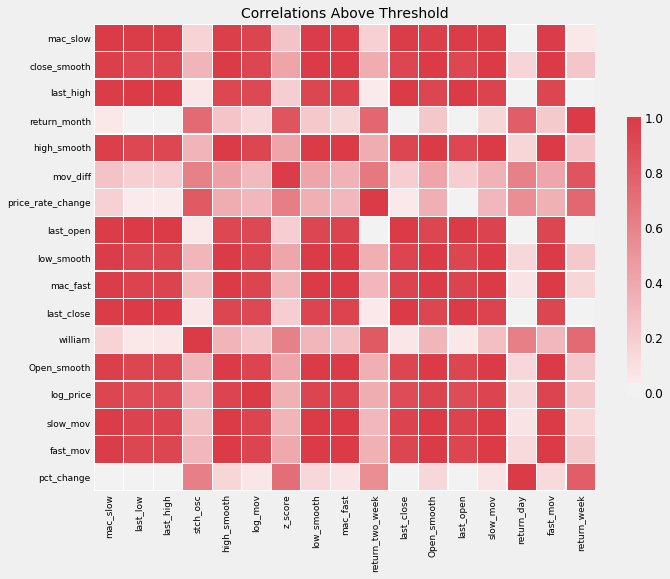

In [ ]:
#Identifying Features collinear correlation magnitude
#of 0.975 the plotting it to get a visual of what
#feature 
fs.identify_collinear(correlation_threshold=0.975)
fs.plot_collinear(plot_all=False)

In [ ]:
#Now using feature_selector to identify features
#that have zero importance 
fs.identify_zero_importance(task = 'regression', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[413]	valid_0's auc: 0.972932
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[69]	valid_0's auc: 0.964394
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[331]	valid_0's auc: 0.971787
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[251]	valid_0's auc: 0.99024
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[249]	valid_0's auc: 0.958525
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[356]	valid_0's auc: 0.944361
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	valid_0's auc: 0.995475
Training until validation scores don't improve for 100 rounds.
Early sto

In [ ]:
#Using feature_selector to Identify these 
#features then drop them from my features
fs.identify_low_importance(cumulative_importance = 0.99)

26 features required for cumulative importance of 0.99 after one hot encoding.
9 features do not contribute to cumulative importance of 0.99.



In [ ]:
#Dropping the features that do not contribute
#to the cumulative importance of 0.99
all_to_remove = fs.check_removal()
print(all_to_remove)
clean_removed_db = train.drop(columns = all_to_remove)

Total of 19 features identified for removal
['mac_slow', 'last_low', 'last_high', 'stch_osc', 'high_smooth', 'volume_log', 'log_mov', 'z_score', 'low_smooth', 'mac_fast', 'return_two_week', 'last_close', 'Open_smooth', 'last_open', 'log_price', 'slow_mov', 'return_day', 'fast_mov', 'return_week']


In [ ]:
clean_removed_db.head()

,close_smooth,volume_smooth,rsi,william,price_rate_change,log_diff,mov_diff,mac_diff,pct_change,sp_return,return_month,return_two_day,return_diff_sp,return_sp_std,return_std,high_low
27,7.443060,1.759144e+07,56.776322,-23.889661,0.002610,0.013070,0.165033,-0.009463,-0.004116,-0.040642,0.051001,-0.003244,0.036525,0.018577,0.092576,0.823180
28,7.360448,1.662486e+07,53.788628,-29.501440,0.033053,-0.004522,0.076121,0.087901,-0.011099,-0.043872,0.018113,-0.015170,0.032772,0.018592,0.087473,0.804544
29,7.250358,1.628024e+07,50.011784,-36.979755,0.041725,-0.020072,-0.022436,0.154921,-0.014957,-0.047520,-0.019109,-0.025890,0.032563,0.018267,0.080035,0.729635
30,7.034287,1.598216e+07,43.548565,-51.657367,0.031728,-0.042068,-0.130806,0.174694,-0.029802,-0.054648,-0.057986,-0.044313,0.024846,0.018072,0.073462,0.633708
31,6.917429,1.462347e+07,40.500138,-59.595412,0.031471,-0.046073,-0.210740,0.150684,-0.016613,-0.056034,-0.074446,-0.045919,0.039421,0.017224,0.067985,0.558967


In [ ]:
clean_removed_db.columns

Index(['close_smooth', 'volume_smooth', 'rsi', 'william', 'price_rate_change',
       'log_diff', 'mov_diff', 'mac_diff', 'pct_change', 'sp_return',
       'return_month', 'return_two_day', 'return_diff_sp', 'return_sp_std',
       'return_std', 'high_low'],
      dtype='object')

In [ ]:
#To shape the data into X_train,X_test and y_train,y_test
length = clean_removed_db.shape[0]
split = int(length * 0.80)
split 

385

In [ ]:
clean_removed_db.shape[0]

482

In [ ]:
#Splitting the data into Train and Test
X_train, X_test = clean_removed_db[:split], clean_removed_db[split:]
y_train, y_test = train_labels[:split], train_labels[split:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(385, 16) (97, 16)
(385,) (97,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#Setting up my RandomForest and Parameter values set to 
#Hyperparameter tuning below 
classifier = RandomForestClassifier(n_estimators=30,max_depth=30,max_features='sqrt',min_samples_leaf=15,min_samples_split=2,random_state=42)

In [ ]:
#Fitting the data to my RandomForest
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
#Predicting the next values
y_pred = classifier.predict(X_test)

In [ ]:
#printing the accuracy score to assess model
accuracy_score(y_test,y_pred)

0.8144329896907216

In [ ]:
print(classification_report(y_test, y_pred, labels=[1, 0]))

             precision    recall  f1-score   support

          1       0.87      0.90      0.88        77
          0       0.56      0.50      0.53        20

avg / total       0.81      0.81      0.81        97



In [ ]:
#Building a simple Loop to hyper tune for optimal parameters
#I was lucky enough to land on a good range when I first started
#so thats why params are set to the way they are
#also for Max_depth I assign 30 because of an article from
#Cornell University on Random Forest's
hyper_param = []
for x in range(1,64):
  for t in range(1,26):
    for y in range(2,3):
      classifier = RandomForestClassifier(n_estimators=x,max_depth=30,max_features='sqrt',min_samples_leaf=t,min_samples_split=y,random_state=42)
      classifier.fit(X_train,y_train)
      y_pred = classifier.predict(X_test)
      accuracy = accuracy_score(y_test,y_pred)
      accuracy_list = [accuracy.tolist(), x, t, y]
      hyper_param.append(accuracy_list)     
      print(x,t,y,accuracy)

1 1 2 0.711340206185567
1 2 2 0.5257731958762887
1 3 2 0.6288659793814433
1 4 2 0.6082474226804123
1 5 2 0.5979381443298969
1 6 2 0.44329896907216493
1 7 2 0.35051546391752575
1 8 2 0.6185567010309279
1 9 2 0.6597938144329897
1 10 2 0.6701030927835051
1 11 2 0.7731958762886598
1 12 2 0.6804123711340206
1 13 2 0.7628865979381443
1 14 2 0.7628865979381443
1 15 2 0.4020618556701031
1 16 2 0.4020618556701031
1 17 2 0.6804123711340206
1 18 2 0.7216494845360825
1 19 2 0.7216494845360825
1 20 2 0.5051546391752577
1 21 2 0.5051546391752577
1 22 2 0.4948453608247423
1 23 2 0.4742268041237113
1 24 2 0.7216494845360825
1 25 2 0.7216494845360825
2 1 2 0.31958762886597936
2 2 2 0.41237113402061853
2 3 2 0.5360824742268041
2 4 2 0.5979381443298969
2 5 2 0.5463917525773195
2 6 2 0.4742268041237113
2 7 2 0.6597938144329897
2 8 2 0.6082474226804123
2 9 2 0.6082474226804123
2 10 2 0.6391752577319587
2 11 2 0.7422680412371134
2 12 2 0.6597938144329897
2 13 2 0.7422680412371134
2 14 2 0.7010309278350515
2

In [ ]:
#After I run the loop I need to find top values
for x in hyper_param:
  if x[0] > .79:
    print(x)

[0.7938144329896907, 19, 15, 2]
[0.7938144329896907, 27, 15, 2]
[0.7938144329896907, 28, 15, 2]
[0.8041237113402062, 29, 15, 2]
[0.8144329896907216, 30, 15, 2]
[0.8041237113402062, 31, 15, 2]


In [ ]:
#Checking out the features importances to plot
#and possible tune my model 
train_feature_list = list(clean_removed_db.columns)
importances = list(classifier.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

[('pct_change', 0.21),
 ('return_two_day', 0.18),
 ('log_diff', 0.14),
 ('sp_return', 0.1),
 ('return_month', 0.06),
 ('close_smooth', 0.05),
 ('william', 0.05),
 ('high_low', 0.04),
 ('volume_smooth', 0.03),
 ('price_rate_change', 0.03),
 ('mov_diff', 0.03),
 ('mac_diff', 0.03),
 ('return_diff_sp', 0.02),
 ('rsi', 0.01),
 ('return_sp_std', 0.01),
 ('return_std', 0.01)]

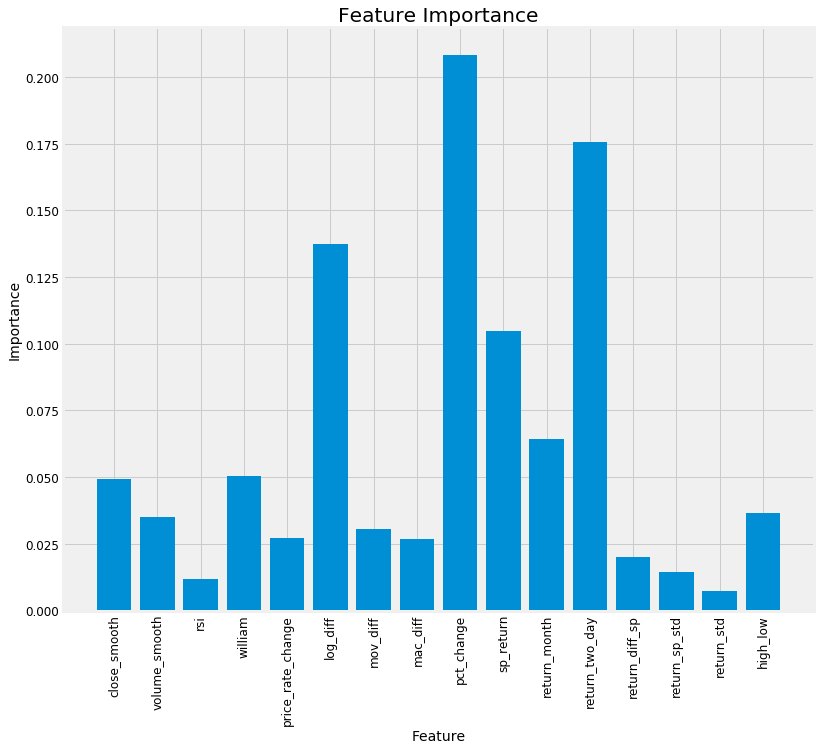

In [ ]:
#Plotting the features to see visually my 
#features importances
x_values = list(range(len(importances)))

plt.figure(figsize=(12,10))
plt.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, train_feature_list, rotation='vertical')
plt.grid(True)
plt.box(True)
plt.rcParams["figure.facecolor"] = "w"

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importance');